# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## RNN Advanced Section Supplimentary Material
## Bayesian Optimized Reservoir Computing with PyTorch and Botorch, RcTorch!

**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner <br/>
**Authors**: Hayden Joy, Marios Mattheakis, and Pavlos Protopapas 


<hr style="height:2pt">

rctorch github repository: https://github.com/blindedjoy/RcTorch

In [1]:
import numpy as np
from numpy import loadtxt

#from pyESN import ESN
from matplotlib import pyplot as plt
%matplotlib inline

### to install rctorch in jupyterhub-gpu open a terminal and then enter:
`>>> pip3 install rctorch`
if that fails first try `pip3 install botorch`

In [2]:
#from rctorchprivate import *
from rctorchprivate import *
#from RcTorchPrivate import *

## helper functions

In [3]:
!ls

AUTHORS                            dist
CHANGES                            final_notebooks
Example.ipynb                      forced_pendulum.ipynb
Hennon Hailes.ipynb                hamiltonian_rc_example_1.ipynb
LICENSE.txt                        hamiltonian_rc_example_1_Joy.ipynb
NumericalSolvers.ipynb             meta.yaml
NumericalSolvers.ipynb.zip         rc_diff_eq.ipynb_files
README.md                          rctorch_private.egg-info
RcTorch.egg-info                   rctorchprivate
__MACOSX                           rctorchprivate.egg-info
__init__.py                        requirements.txt
build                              results
data                               setup.py
denoising.ipynb                    test.pkl


In [4]:
def myMSE(prediction,target):
    try:
        prediction = prediction.numpy()
    except:
        pass
    return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

def residuals(prediction,target):
    try:
        prediction = prediction.numpy()
    except:
        pass
    return (target.flatten() - prediction.flatten())

def plotResults(trainlen, testlen, data, yfit, yhat, resTrain, resTest):
    """
    Arguments:
        trainlen: the length of the training set
        testlen: the length of the test set
        data: the entire dataset
        yfit: the prediction of the RC on the training set 
        yhat: the prediction of the RC on an unseen test set
        resTrain: training residuals
        resTest: test residuals
    """
    #data plot
    plt.figure(figsize=(14,6))
    plt.subplot(2,1,1)
    plt.plot(range(0,trainlen+testlen),data[:(trainlen+testlen)],'k',  linewidth=2, label="data")
    plt.plot(range(0,trainlen),yfit,'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), yhat,'--r', linewidth=2,  alpha=1, label="test")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('x')
    plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)

    
    #Residuals plot
    plt.subplot(2,1,2)
    plt.plot(range(0,trainlen),  np.abs(resTrain),'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), np.abs(resTest),'--r', linewidth=2,  alpha=1, label="test")
    lo, hi = plt.ylim()
    plt.yscale("log") 
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('Residuals')



# RcTorch: 

RcTorch is a GPU accelerated pytorch library that uses Facebook's bayesian optimization package BoTorch to quickly optimize the hyper-parameters of reservoir nueral networks. This library is still in its early stages so feel free to email Hayden Joy hjoy@college.harvard.edu with any questions or to report any bugs. For this reason please also check for updates here: https://pypi.org/project/rctorch/.

(a huge thank you to Reinier https://github.com/1Reinier/Reservoir who wrote the first version of this library and most of this documentation. See the paper here: https://arxiv.org/abs/1903.05071)

J. R. Maat, N. Gianniotis, “Reservoir: a Python Package to Train and Optimize Echo State Networks ,” 2017. [Online]. Available: http://github.com/https://github.com/1Reinier/Reservoir

The open source code in this package supplements:
J. R. Maat, N. Gianniotis and P. Protopapas, "Efficient Optimization of Echo State Networks for Time Series Datasets," 2018 International Joint Conference on Neural Networks (IJCNN), Rio de Janeiro, 2018, pp. 1-7.

### The EchoStateNetwork class creates a reservoir neural network according to the following arguments
log-space variables: 
- connectivity: **[float]** the probability that two nodes will be connected
- regularization: **[float default value None]** The L2 regularization value used in Ridge regression for model inference
    
lin-space variables: 
- bias **[recommended value 1.5]**: bias to be added to the input weights.
- leaking_rate **[float recommended value: ]**: Specifies how much of the state's update 'leaks' into the new state
- spectral_radius **[float search between 1 and 2]**: Sets the magnitude of the largest eigenvalue of the transition matrix (weight matrix) 

Variables we recommend you fix: 
 - n_nodes **[recommended value 1000]**: Number of nodes that together make up the reservoir
 - input_scaling: **[float, default value 0.5]**
     The scaling of input values into the network
 - feedback scaling: **[float, default value 0.5]** the scaling of feedback values into the network
 
Other arguments:
 - feedback: **[bool]** Sets feedback of the last value into the network on or off (for predictions predicted values are substituted for y)
 - random seed: **[int]** Seed used to initialize RandomState (Torch Generator manual seed) in reservoir generation and weight initialization
 - activation function: **[nn.function]** recurrent activation function. only nn.tanh implimented. Leave as is
 
### The EchoStateNetworkCV class performs cross-validated Bayesian Optimization on variables of your choice

Arguments:
- bounds = The bounds dict declares trainable and fixed variables. Certain variables are searched in log-space and other are in lin-space. All variables are the dictionary keys. if a numeric value (not a tuple) is assigned to a variable (ie hyper-parameter) it is assumed to be fixed. If it is assigned to be a tuple then then the value is ([lower bound], [upper bound]). 
- intial samples: **[int recommended value >= 50]** The number of random samples to explore before starting the optimization.
- validate_fraction **[float ]** the fraction of the data that may be used as a validation set
- batch_size: **[int]** Batch size of samples used by BoTorch (these are run in parallel and with cuda if possible)
- cv_samples: **[int]** number of samples of the objective function to evaluate for a given parameterization of the ESN
- scoring method: {'mse', 'nmse'} Evaluation metric that is used to guide optimization
- esn_burn_in: **[int]** the number of time steps to discard upon training a single Echo State Network
- esn_feedback: builds ESNs with feedback ('teacher forcing') if available
- device: Torch device (either 'cpu' or 'cuda')
- interactive **[BOOL]** if true, make interactive python plots
- approximate reservoir **[BOOL NOT IMPLIMENTED]** use sparse matrices to speed up optimization
- activation function: **[nn.function]** only nn.tanh implimented

Trust Region Bayesian Optimization (TURBO) 

TURBO Arguments: (<a href='https://botorch.org/tutorials/turbo_1'>Botorch tutorial</a>) (<a href='https://arxiv.org/pdf/1910.01739.pdf'> click here for the original paper</a>  which came out of uber.
Turbo Arguments *we don't recommend that you change these values but they are here for your understanding)*
- failure tolerance [**int, automated**] the number of times that a model can fail to improve length before length is increased in turbo algorithm.
- sucess tolerance: [**int**] the number of times that a model can succeed to improve length before length is decreased in turbo algorithm.
- length min: [**int**] the target length that acts as the stopping condition for the turbo algorithm
- length max: [**int**] maximum length that the turbo algorithm can take before
    
Further arguments
- windowsOS: [**bool**] NOT IMPLIMENTED: use this if you have a windows system with a GPU
- steps ahead: leave as None. Vestigal argument.

     
    
    

###  Data: <a href='https://en.wikipedia.org/wiki/Hénon–Heiles_system'>The Henon-Heiles System</a>

In [5]:
# lines = loadtxt("filename.dat", comments="#", delimiter=",", unpack=False)
tdata = loadtxt("data/HenonHeiles/t.dat")
xdata = loadtxt("data/HenonHeiles/x.dat")
ydata = loadtxt("data/HenonHeiles/y.dat")

tdata = tdata.astype('float32')
xdata = xdata.astype('float32')
ydata = ydata.astype('float32')

The time series consist of  1000  points.


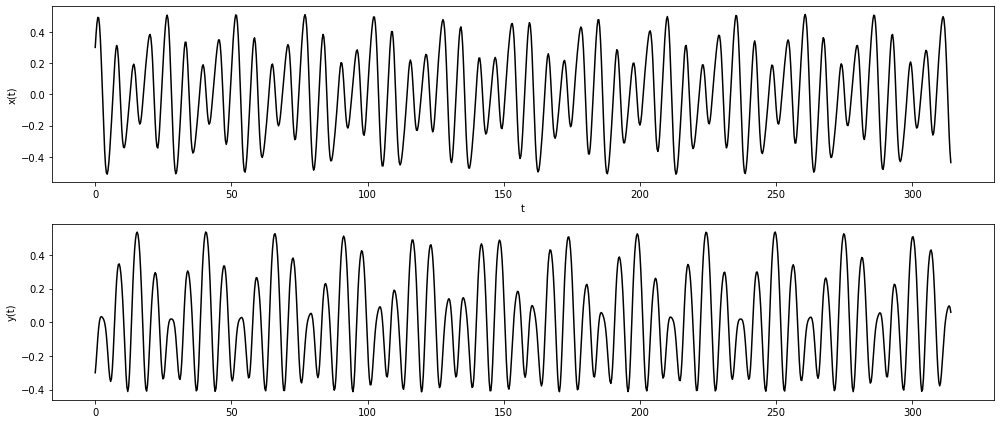

In [6]:



N = len(tdata)
print("The time series consist of ", N, " points.")

plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(tdata,xdata,'k')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(2,1,2)
plt.plot(tdata,ydata,'k')
plt.ylabel('y(t)')
plt.tight_layout()



#### Short range forecast

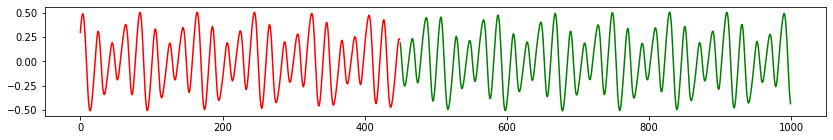

In [7]:
split = 0.45
trainlen = int(split*N)
testlen  = int((1-split)*N)
# trainlen = int(0.5*N)
# testlen  = int(0.5*N)


# Input  data equivalents:
#ttrain = np.ones(trainlen)
#ttest=np.ones(testlen)

# ttrain = tdata[:trainlen]
# ttest  = tdata[trainlen:trainlen+testlen]

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]

plt.figure(figsize=(14,2))

plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

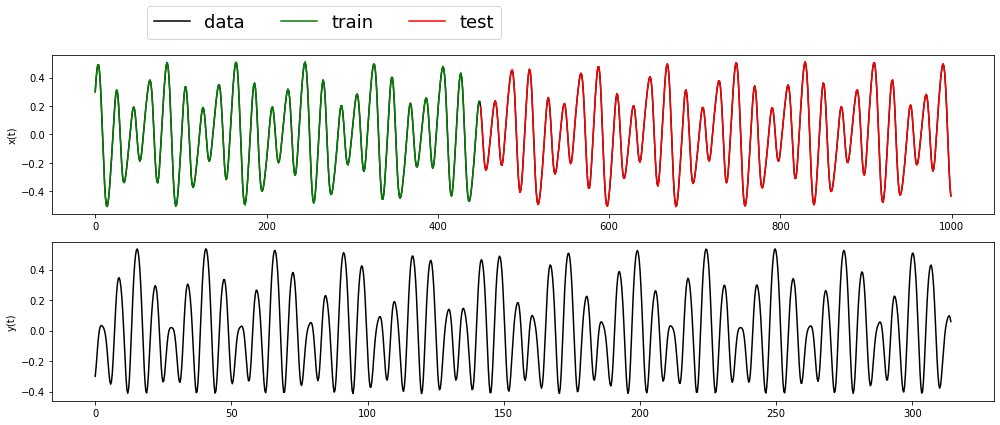

In [8]:


def plot_data(train, test, ydata):
    plt.figure(figsize=(14,6))
    plt.subplot(2,1,1)
    if isinstance(train, np.ndarray):
        train, test = torch.tensor(train), torch.tensor(test)
    trainlen, testlen = len(train), len(test)
    plt.plot(range(0,trainlen+testlen),hstack((train,test)),'k',label='data')
    plt.plot(range(0,trainlen), train,'g',label='train')
    plt.plot(range(trainlen,trainlen+testlen), test,'-r',label='test')
    plt.ylabel('x(t)')
    plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)
    plt.subplot(2,1,2)
    plt.plot(tdata,ydata,'k')
    plt.ylabel('y(t)')
    plt.tight_layout()
    plt.show()


plot_data(xtrain, xtest, ydata)

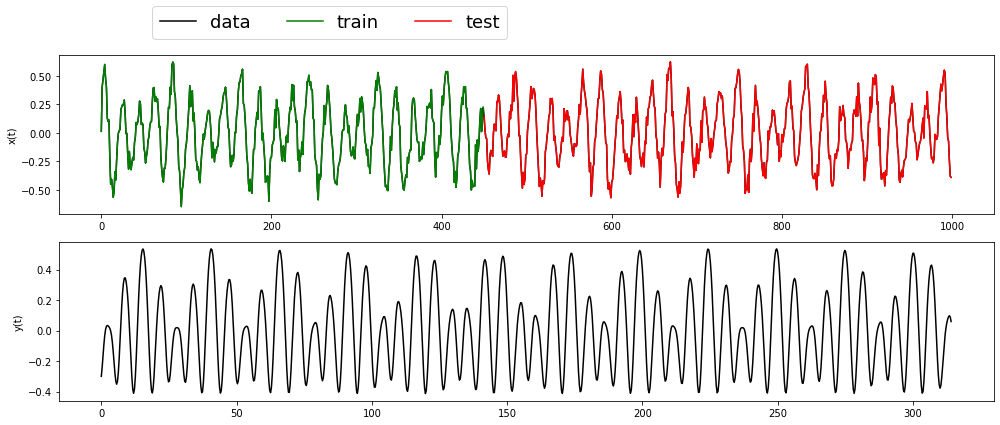

In [9]:
def make_noisy_data(tensor_, std = 0.07, split = 0.45):
    tensor_ = torch.tensor(tensor_)
    tensor_ = tensor_ + torch.normal(0,std, size = tensor_.shape)
    #total_length
    tl = len(tensor_)
    trainlen = int(tl * split)
    train, test = tensor_[:trainlen], tensor_[trainlen:]
    return train, test

xtrain_noisy, xtest_noisy = make_noisy_data(xdata)

#plot_data(xtrain_noisy, xtest_noisy)
#plot_data(xtrain, xtest, ydata)

plot_data(xtrain_noisy, xtest_noisy, ydata)

# RcTorch pure prediction

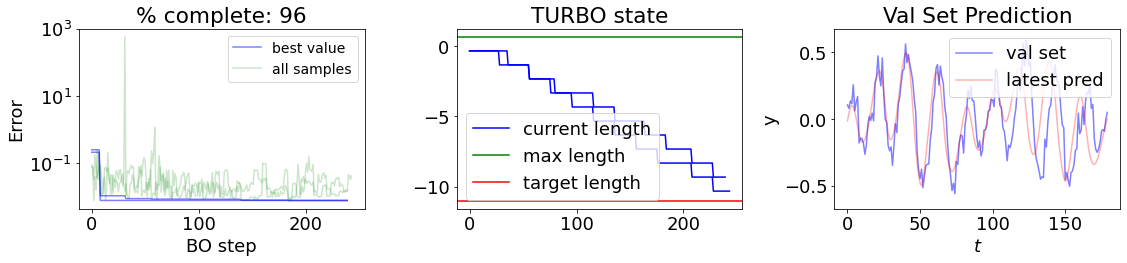

Trust region 0 : Y_next tensor([[-0.0463],
        [-0.0426],
        [-0.0323],
        [-0.0425]])


KeyboardInterrupt: 

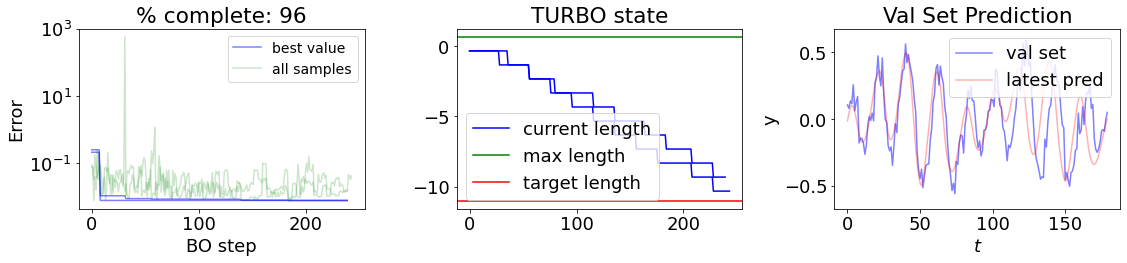

In [116]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 500,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "nmse", interactive = True, 
                            batch_size = 4, cv_samples = 1, initial_samples = 8, 
                            subsequence_length = int(ytrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 3, ODE_order = None,
                            length_min = 2**-11,
                            validate_fraction = 0.5,
                            n_inputs = 1,
                            n_outputs = 1
                            
           )
#optimize:
opt_hps = esn_cv.optimize( n_trust_regions = 2, max_evals = 500, y = xtrain_noisy.reshape(-1,1))

In [10]:


def recover_hps(self):
    best_vals = self.X_turbo[torch.argmax(self.Y_turbo)]
        
    denormed_ = self.denormalize_bounds(best_vals)

    try:
        denormed_ = denormalize_bounds(best_vals)
    except:
        print("FAIL")

    #best_vals = X_turbo[torch.argmax(Y_turbo)]

    #####Bad temporary code to change it back into a dictionary
    denormed_free_parameters = list(zip(self.free_parameters, denormed_))
    denormed_free_parameters = dict([ (item[0], item[1].item()) for item in denormed_free_parameters])

    best_hyper_parameters = denormed_free_parameters
    for fixed_parameter in self.fixed_parameters:
        best_hyper_parameters = {fixed_parameter : self.bounds[fixed_parameter], **best_hyper_parameters }

    #log_vars = ['connectivity', 'llambda', 'llambda2', 'noise', 'regularization', 'dt']
    for var in self.log_vars:
        if var in best_hyper_parameters:
            best_hyper_parameters[var] = 10. ** best_hyper_parameters[var] 



    # Return best parameters
    return best_hyper_parameters

In [11]:
xdata_noisy = hstack((xtrain_noisy, xtest_noisy))

Training mean square error:  0.030622177
Testing  mean square error:  0.40629482


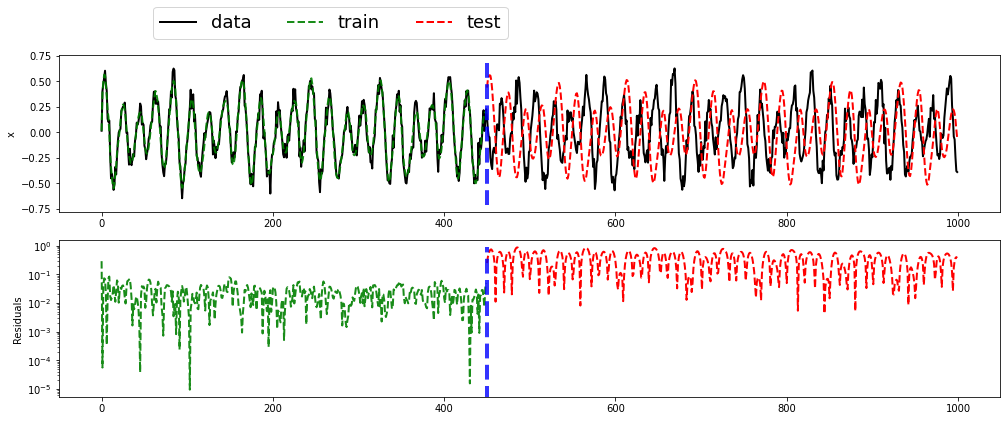

In [24]:
pure_pred_noise_hps = {'n_nodes': 500,
 'connectivity': 0.12408451143662941,
 'spectral_radius': 1.1268014907836914,
 'regularization': 0.022762411251526036,
 'leaking_rate': 0.2863200306892395,
 'bias': 0.32563644647598267}


esn = EchoStateNetwork(**pure_pred_noise_hps, random_state = 209, feedback = 1, n_inputs = 1, n_outputs = 1)
xfit = esn.fit(y = xtrain_noisy.reshape(-1,1), burn_in = 0)
scoreTest, xhat = esn.test(y = xtest_noisy.reshape(-1,1), y_start = -67789078680)

# MSE in the training and testing
scoreTrain = myMSE(xfit,xtrain)
scoreTest = myMSE(xhat,xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit, xtrain);
resTest = residuals(xhat, xtest);

# Plot:
plotResults(trainlen, testlen, xdata_noisy, xfit, xhat, resTrain, resTest)

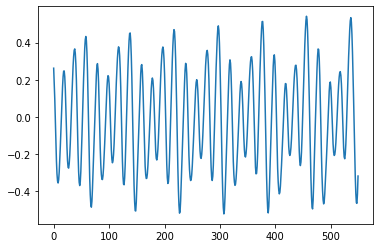

In [17]:
plt.plot(xhat)

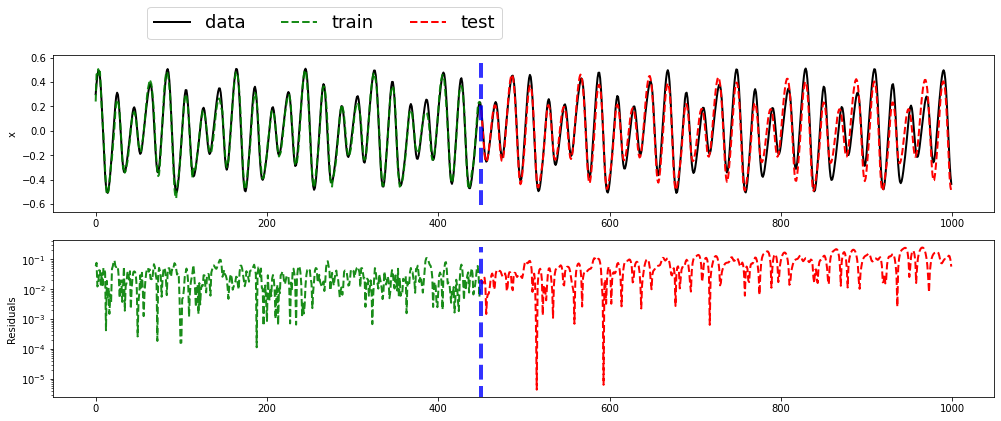

In [23]:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

FAIL


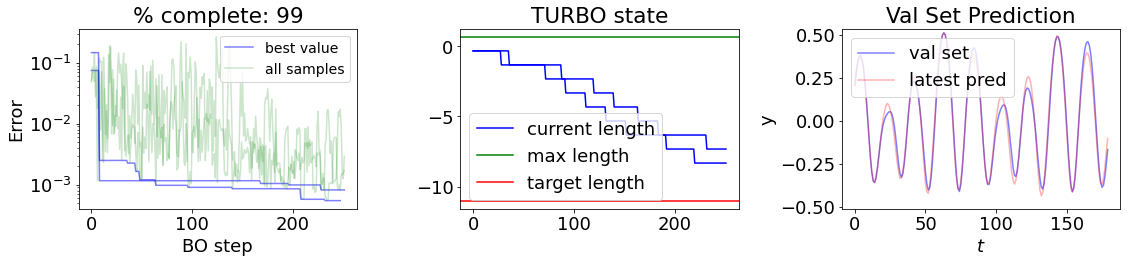

In [109]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 500,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "nmse", interactive = True, 
                            batch_size = 4, cv_samples = 1, initial_samples = 8, 
                            subsequence_length = int(ytrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 3, ODE_order = None,
                            length_min = 2**-11,
                            validate_fraction = 0.5,
                            n_inputs = 1,
                            n_outputs = 1
                            
           )
#optimize:
opt_hps = esn_cv.optimize( n_trust_regions = 2, max_evals = 500,
                            x = xtrain_noisy.reshape(-1,1), y =ytrain.reshape(-1,1))

In [110]:
opt_hps

{'n_nodes': 500,
 'connectivity': 0.32094487651215875,
 'spectral_radius': 1.23499596118927,
 'regularization': 0.8368901513227046,
 'leaking_rate': 0.32397231459617615,
 'bias': 0.24689573049545288}

Training mean square error:  0.008211381
Testing  mean square error:  0.0373826


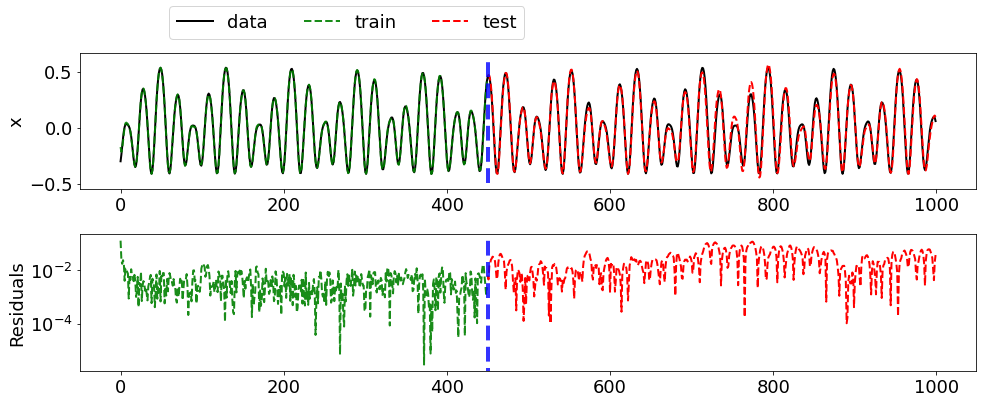

In [130]:
# first_denoise_hps = {'n_nodes': 200,
#  'connectivity': 0.29002750025150953,
#  'spectral_radius': 1.2885233163833618,
#  'regularization': 0.013653433082063734,
#  'leaking_rate': 0.5670961141586304,
#  'bias': 0.3260454535484314}

noise_hps = {'n_nodes': 500,
 'connectivity': 0.32094487651215875,
 'spectral_radius': 1.23499596118927,
 'regularization': 0.8368901513227046,
 'leaking_rate': 0.32397231459617615,
 'bias': 0.24689573049545288}
#trained from x to y, appear to be generally good denoising parameters for this equation.

esn = EchoStateNetwork(**noise_hps, random_state = 209, feedback = 1, n_inputs = 1, n_outputs = 1)
yfit = esn.fit(X = xtrain_noisy.reshape(-1,1), y = ytrain, burn_in = 0)
scoreTest, yhat = esn.test(X = xtest_noisy.reshape(-1,1), y =ytest.reshape(-1,1))

# MSE in the training and testing
scoreTrain = myMSE(yfit,ytrain)
scoreTest = myMSE(yhat,ytest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(yfit, ytrain);
resTest = residuals(yhat, ytest);

# Plot:
plotResults(trainlen, testlen, ydata, yfit, yhat, resTrain, resTest)

Training mean square error:  0.009250803
Testing  mean square error:  0.024390548


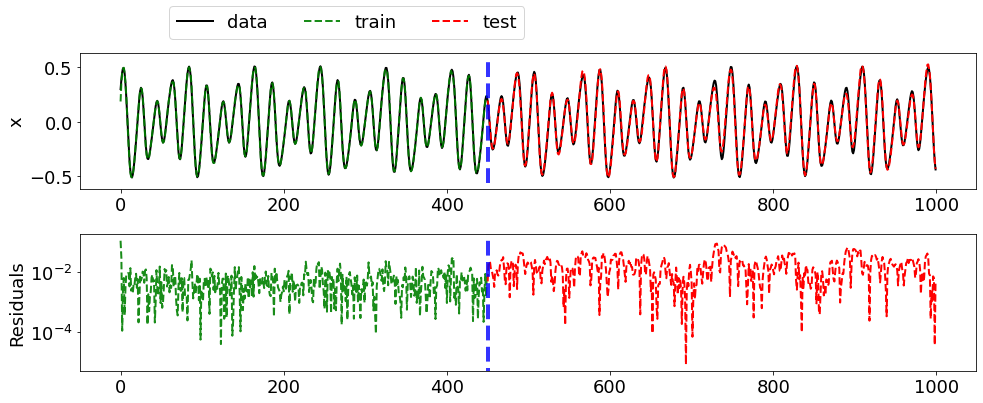

In [129]:
esn = EchoStateNetwork(**noise_hps, random_state = 209, feedback = 1, n_inputs = 1, n_outputs = 1)
xfit = esn.fit(X = xtrain_noisy.reshape(-1,1), y = xtrain, burn_in = 0)
scoreTest, xhat = esn.test(X = xtest_noisy.reshape(-1,1), y =xtest.reshape(-1,1))


# MSE in the training and testing
scoreTrain = myMSE(xfit,xtrain)
scoreTest = myMSE(xhat,xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit, xtrain);
resTest = residuals(xhat, xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

In [104]:
esn.extended_states.shape, esn.X.shape
# optimized_hyper_params = {'n_nodes': 200,
#  'connectivity': 0.4483155375901789,
#  'spectral_radius': 1.5525517463684082,
#  'regularization': 0.005069355134121151,
#  'leaking_rate': 0.6272786855697632,
#  'bias': 0.750773549079895}

(torch.Size([450, 201]), torch.Size([450, 1]))

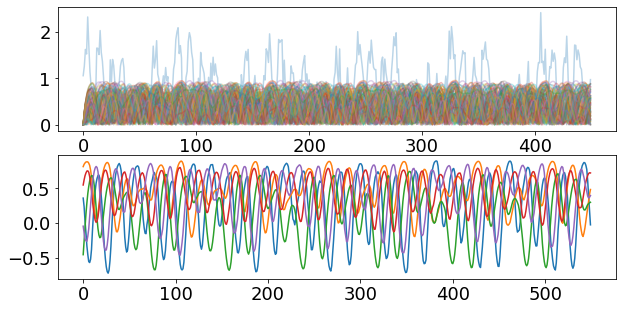

In [144]:
fig, ax = plt.subplots(2,1, figsize = (10,5))
plt.sca(ax[0])
plt.plot(torch.abs(esn.extended_states[:,0:100]), alpha = 0.3)
plt.sca(ax[1])
plt.plot(esn.val_states[:,0:5])

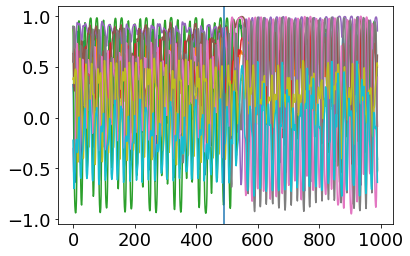

In [106]:
states2plot = 10
index2start = 10
valstates2plot =1000
combined_states = torch.cat((esn.extended_states[:,1:states2plot+1], esn.val_states[0:valstates2plot, 0:states2plot]))
plt.plot(combined_states[index2start:])
plt.axvline(500-index2start)

In [132]:
optimized_hyper_params

NameError: name 'optimized_hyper_params' is not defined

In [136]:
assert False

AssertionError: 

#### Long range forecast (inference)

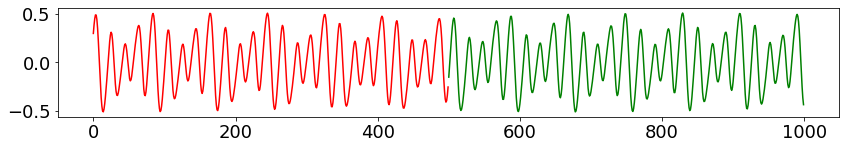

In [137]:
trainlen = int(0.5*N)
testlen  = int(0.5*N)

# Input  data
ttrain = np.ones(trainlen)
ttest=np.ones(testlen)

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]


plt.figure(figsize=(14,2))
plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

## RcTorch Observers Solution

In [ ]:
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 200,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "nmse", interactive = True, 
                            batch_size = 1, cv_samples = 2, initial_samples = 10, 
                            subsequence_length = int(ytrain.shape[0] * 0.9),
                            length_min = 2**-11,
                            random_seed = 123)
optimized_hyper_params = esn_cv.optimize(y = xtrain.reshape(-1,1), x = ytrain.reshape(-1,1), 
                                         n_outputs = 1, n_trust_regions = 2, max_evals = 500)

In [ ]:
esn_cv.parallel_arguments.keys()
esn_cv.parallel_arguments['declaration_args']

In [138]:

opt_hps_ = hyper_params = {'n_nodes': 200,
 'connectivity': 0.13505189245513274,
 'spectral_radius': 1.6877728700637817,
 'regularization': 0.04002294006918671,
 'leaking_rate': 0.2642587423324585,
 'bias': 0.7290011644363403}


In [139]:
esn = EchoStateNetwork(**opt_hps_, random_state = 123, feedback = 0)
xfit = esn.fit(y = xtrain, X = ytrain, burn_in = 0)
xfit = xfit.reshape(-1)
#scoreTrain, yfit = esn.test(y = ytrain)
#scoreTest, xhat = esn.test(y = xtest, X = ytest)
scoreTest, test_outputs, test_input = esn.test(y = xtest.reshape(-1,1), X = ytest)
xhat = test_outputs["yhat"]


# MSE in the training and testing
scoreTrain = myMSE(xfit, xtrain)
scoreTest = myMSE(xhat, xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit,xtrain);
resTest = residuals(xhat,xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

AssertionError: you must enter n_inputs. This is the number of input time series (int)

In [ ]:
plt.plot(test_outputs["yhat"])
plt.plot(test_outputs['ytest'])

In [ ]:
plt.plot(esn.X_val_extended.detach())

In [ ]:
plt.plot(esn.extended_states[:,:10]); torch.std(esn.extended_states[:,0])

In [ ]:
esn = EchoStateNetwork(**hyper_params, random_state = 209, feedback = 0)
xfit = esn.fit(y = xtrain, burn_in = 0)
print(xfit[0].shape)
xfit = xfit.reshape(-1)
#return score, {"yhat": y_predicted.data, "ytest": y}, X[self.burn_in:]
scoreTest, test_outputs, test_input = esn.test(y = xtest.reshape(-1,1))
xhat = test_outputs["yhat"]


# MSE in the training and testing
scoreTrain = myMSE(xfit,xtrain)
scoreTest = myMSE(xhat,xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit, xtrain);
resTest = residuals(xhat, xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

In [ ]:
# 2 and 1/4 cups (280g) all-purpose flour (spoon & leveled)
# 1 teaspoon baking soda
# 1 and 1/2 teaspoons cornstarch*
# 1/2 teaspoon salt
# 3/4 cup (1.5 sticks or 170g) unsalted butter, melted & slightly cooled*
# 3/4 cup (150g) packed light or dark brown sugar
# 1/2 cup (100g) granulated sugar
# 1 large egg + 1 egg yolk, at room temperature
# 2 teaspoons pure vanilla extract
# 1 and 1/4 cups (225g) semi-sweet chocolate chips or chocolate chunks

In [ ]:
class Cookie:
    """A generic cookie class"""
    calories_per_gram  = {"sugar" : 4, "butter" : 7,
                          "cornstarch" : 4, "egg" : 2,
                         "chocolate_chips" : 5}
    
    def __init__(self, cookie_type, sugar_grams):
        self.cookie_type,  self.sugar_grams = cookie_type,  sugar_grams
    
    @staticmethod
    def calc_cal(ingredient_dict, calories_per_gram):
        total_calories = 0
        for ingredient, amount in ingredient_dict.items():
            total_calories += amount * calories_per_gram[ingredient]
        return total_calories

class Chocolate_chip(Cookie):
    """A chocolate chip cookie recipe!"""
    def __init__(self, num_chocolate_chips):
        self.cookie_type = "chocolate_chip"
        self.num_choc_chips = num_chocolate_chips
        #grams
        self.ingredient_dict = { "sugar" : 32, "butter" : 170,
                                 "chocolate_chips" : num_chocolate_chips,
                                 "cornstarch" : 12, "egg" : 50
                                }
        self.num_cookies = 16
    
    def __str__(self):
        total_calories = self.calc_cal(self.ingredient_dict, self.calories_per_gram)
        cal_per_cookie = round(total_calories/self.num_cookies)
        cchips = self.ingredient_dict
        return 'I am a {} with {} calories and {} chocolate chips'.format(
                self.cookie_type, cal_per_cookie, self.num_choc_chips)

In [ ]:
my_cookie = Chocolate_chip(num_chocolate_chips = 30)
print(my_cookie)

In [ ]:
n_init = 10
batch_size = 2
n_trust_regions = 5
_idx = np.zeros((0, 1), dtype=int)
_idx

In [ ]:
for i in range(n_trust_regions):
    _idx = np.vstack((_idx, i * np.ones((n_init, 1), dtype=int)))

In [ ]:
_idx

In [ ]:
for i in range(n_trust_regions):
    idx = np.where(_idx == i)[0]
    print(idx)
    print(len(idx))


In [ ]:
X_init = torch.ones(7,1)
nrow = X_init.shape[0]
batch_size = 4

In [ ]:
clean_batches = nrow // batch_size
for i in range(clean_batches):
    print(i)
    print(list(range(i*batch_size , ((i+1)*batch_size))))
else:
    still2do = nrow-clean_batches*batch_size
    print(list(range(nrow - still2do, nrow)))

In [ ]:
hi = {0:0}

In [ ]:
hi

In [ ]:
class Tesla:
    def __init__(self, model, year = 2021):
        self.year, self.model  = year, model

# Create a class instance
my_tesla = Tesla("X")

print(my_tesla)
my_tesla()

In [ ]:
cars = ["volvo", "nissan", "hyundai"]
cars()